In [1]:
pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 4.6 MB/s eta 0:00:00


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from kerastuner.tuners import RandomSearch
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

<ipython-input-2-69014c430059>:9: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


# Load the dataset

In [3]:
train_data_path = '/content/credit_card_fraud.csv'
train_data = pd.read_csv(train_data_path)

In [4]:
train_data.head()

,Transaction Date and Time,Transaction Amount,Cardholder Name,Card Number (Hashed or Encrypted),Merchant Name,Merchant Category Code (MCC),Transaction Location (City or ZIP Code),Transaction Currency,Card Type,Card Expiration Date,CVV Code (Hashed or Encrypted),Transaction Response Code,Transaction ID,Fraud Flag or Label,Previous Transactions,Transaction Source,IP Address,Device Information,User Account Information,Transaction Notes
0,2022-09-24 13:54:27,285.88,Shray Soman,daca51bffe0fc4eaaa7c430917f94b75fd893712492254...,"Rajagopalan, Ghose and Kant",3590,Khammam,INR,MasterCard,04/29,01299ac65733b5a3d774265fbfe8396b8611e5e3321855...,5,b7f69cbc-a03d-41f8-adca-75920b0242c3,1,None,Online,18.106.240.6,Tablet,NaN,Consequatur corporis minima ad vero deserunt n...
1,2020-07-24 11:20:13,1777.32,Lakshit Bakshi,d5366dd9be3a0266c0252baceaa6332210ed4dbd0ef252...,Sule PLC,7277,Vasai-Virar,EUR,American Express,03/26,ad8fa913d25b3970c6efa8ca504da8ba670ce2a9cf012d...,12,ad53cc8e-8412-422e-8cad-4176daac8387,1,None,Online,212.48.185.128,Mobile,jloyal,Dolore repellendus odio deleniti. Eaque quibus...
2,2023-03-18 01:05:36,3939.01,Riya Bobal,4737a6384aa1c3c31f7768b86633d6a8401dd6ab4a8ff1...,Badal PLC,9297,Nangloi Jat,USD,Visa,11/29,eb3be230bbd2844b1f5d8f2e4fab9ffba8ab22cfeeb69c...,5,f09cecd6-0d74-4551-8089-a31d64e6b9c5,1,3 or more,In-Person,17.190.112.46,Mobile,NaN,Unde beatae perspiciatis sapiente. Voluptates ...
3,2021-01-07 21:53:04,376.44,Mohanlal Balakrishnan,4721806eed8f2663bb597ff13e79a294de318358fbb54b...,Konda-Sodhi,5686,Ramagundam,USD,Visa,09/25,891d46993a36d78392247c642138cede01d9841daab1d9...,5,b208ae0b-4c4f-428f-b6b9-5360b288b947,0,2,In-Person,153.136.24.104,Tablet,NaN,Cupiditate repellendus necessitatibus quo occa...
4,2021-12-16 06:22:24,1687.33,Mannat Rout,9deacc3a9efd6e382826d400620aca5f23ed94327578e5...,Dua Ltd,2940,Adoni,INR,MasterCard,03/31,48a1a756f2d83f1dc57bbf14052b70a6f40d0fceed6662...,5,6b4e4e43-5b73-4906-9973-299a1b2a5e71,1,2,Online,196.153.28.131,Desktop,NaN,Molestias assumenda consectetur itaque veritat...


In [6]:
train_data.shape

(8000, 20)

In [7]:
train_data.columns

Index(['Transaction Date and Time', 'Transaction Amount', 'Cardholder Name',
       'Card Number (Hashed or Encrypted)', 'Merchant Name',
       'Merchant Category Code (MCC)',
       'Transaction Location (City or ZIP Code)', 'Transaction Currency',
       'Card Type', 'Card Expiration Date', 'CVV Code (Hashed or Encrypted)',
       'Transaction Response Code', 'Transaction ID', 'Fraud Flag or Label',
       'Previous Transactions', 'Transaction Source', 'IP Address',
       'Device Information', 'User Account Information', 'Transaction Notes'],
      dtype='object')

In [8]:
columns_to_drop = ['Cardholder Name', 'User Account Information', 'Card Number (Hashed or Encrypted)', 'Card Expiration Date', 'CVV Code (Hashed or Encrypted)', 'Transaction ID']
train_data = train_data.drop(columns=columns_to_drop)


Check for missing values

In [9]:
train_data.isnull().sum()

Transaction Date and Time                  0
Transaction Amount                         0
Merchant Name                              0
Merchant Category Code (MCC)               0
Transaction Location (City or ZIP Code)    0
Transaction Currency                       0
Card Type                                  0
Transaction Response Code                  0
Fraud Flag or Label                        0
Previous Transactions                      0
Transaction Source                         0
IP Address                                 0
Device Information                         0
Transaction Notes                          0
dtype: int64

In [10]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 14 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Transaction Date and Time                8000 non-null   object 
 1   Transaction Amount                       8000 non-null   float64
 2   Merchant Name                            8000 non-null   object 
 3   Merchant Category Code (MCC)             8000 non-null   int64  
 4   Transaction Location (City or ZIP Code)  8000 non-null   object 
 5   Transaction Currency                     8000 non-null   object 
 6   Card Type                                8000 non-null   object 
 7   Transaction Response Code                8000 non-null   int64  
 8   Fraud Flag or Label                      8000 non-null   int64  
 9   Previous Transactions                    8000 non-null   object 
 10  Transaction Source                       8000 no

In [11]:
X = train_data.drop(columns=['Fraud Flag or Label'])
y = train_data['Fraud Flag or Label']

# Identify categorical and numerical columns

In [12]:
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

In [13]:
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [14]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Designing the MLP Model

In [16]:
from kerastuner import HyperModel

class MyHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = Sequential()
        model.add(Dense(units=hp.Int('units_layer_1', min_value=32, max_value=512, step=32),
                        activation='relu', input_shape=self.input_shape))
        model.add(Dense(units=hp.Int('units_layer_2', min_value=32, max_value=512, step=32),
                        activation='relu'))
        model.add(Dense(1, activation='sigmoid'))

        optimizer_choice = hp.Choice('optimizer', ['adam', 'sgd'])

        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

        if optimizer_choice == 'adam':
            optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)
        else:
            optimizer = tf.keras.optimizers.SGD(learning_rate=hp_learning_rate)

        model.compile(optimizer=optimizer,
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

        return model

Run the Hyperparameter Search

In [17]:
tuner = RandomSearch(
    MyHyperModel(input_shape=(X_train.shape[1],)),
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='helloworld')

tuner.search(X_train, y_train, epochs=10, validation_split=0.2)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]


Trial 10 Complete [00h 00m 23s]
val_accuracy: 0.5249999761581421

Best val_accuracy So Far: 0.5249999761581421
Total elapsed time: 00h 02m 53s


Epoch 1/50
160/160 [==============================] - 2s 8ms/step - loss: 0.6934 - accuracy: 0.4930 - val_loss: 0.6933 - val_accuracy: 0.4945
Epoch 2/50
160/160 [==============================] - 1s 5ms/step - loss: 0.6928 - accuracy: 0.5145 - val_loss: 0.6933 - val_accuracy: 0.4930
Epoch 3/50
160/160 [==============================] - 1s 7ms/step - loss: 0.6923 - accuracy: 0.5262 - val_loss: 0.6933 - val_accuracy: 0.4883
Epoch 4/50
160/160 [==============================] - 1s 8ms/step - loss: 0.6918 - accuracy: 0.5357 - val_loss: 0.6934 - val_accuracy: 0.4852
Epoch 5/50
160/160 [==============================] - 1s 6ms/step - loss: 0.6914 - accuracy: 0.5467 - val_loss: 0.6934 - val_accuracy: 0.4836
Epoch 6/50
160/160 [==============================] - 1s 5ms/step - loss: 0.6909 - accuracy: 0.5535 - val_loss: 0.6934 - val_accuracy: 0.4953
Epoch 7/50
160/160 [==============================] - 1s 6ms/step - loss: 0.6904 - accuracy: 0.5521 - val_loss: 0.6935 - val_accuracy: 0.4945
Epoch 

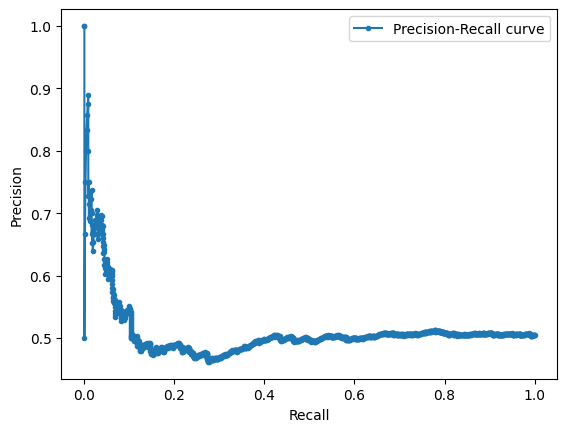

In [18]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2)
y_pred = model.predict(X_test).ravel()
y_pred_class = (y_pred > 0.5).astype("int32")

accuracy = accuracy_score(y_test, y_pred_class)
precision = precision_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class)
f1 = f1_score(y_test, y_pred_class)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

cm = confusion_matrix(y_test, y_pred_class)
print("Confusion Matrix:\n", cm)

precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_pred)
plt.plot(recall_vals, precision_vals, marker='.', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()